## Handwritten Digit Generation with Generative Adversarial Networks (GANs)

Generating handwritten digits (0-9) similar to the digits in the MNIST dataset with a GAN. 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from models import Generator, Discriminator
from util import weight_init

In [3]:
# Load and store the MNIST train data 
transform = transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize([0.5], [0.5])
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

batch_size = 50
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)

100.1%Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw
113.5%Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw
100.4%Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
180.4%Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [6]:
# Load and store the MNIST train data 
transform = transforms.Compose([
    torchvision.transforms.Resize(32),
    torchvision.transforms.CenterCrop(32),
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize([0.5], [0.5])
])


trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)

batch_size = 50

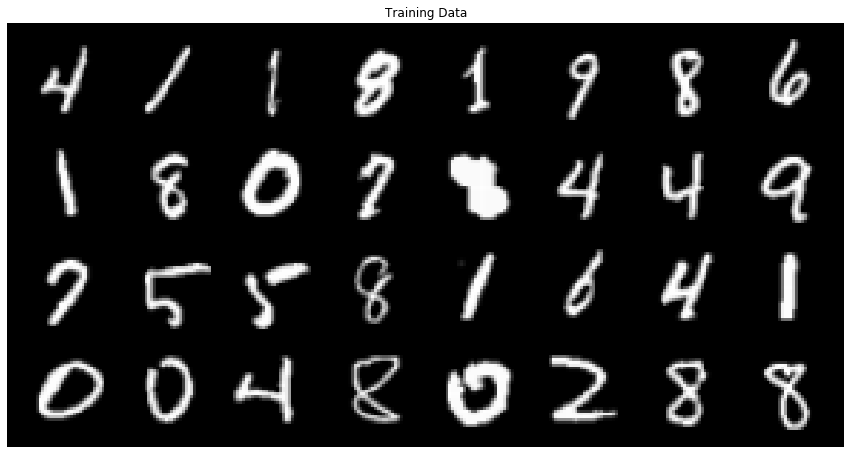

In [7]:

# Visualize some of the training data
plt.figure(figsize=(15, 8))
data, _ = next(iter(trainloader))

# Remove normalization from images and restore original images for correct visualization
data = data * 0.5 + 0.5

grid = torchvision.utils.make_grid(data[:32], nrow=8, padding=4)
plt.imshow(grid.permute(1, 2, 0))
plt.title('Training Data')
plt.axis('off')
plt.show()

In [8]:
# Create Generator and Discriminator networks
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

noise_size = 100
generator = Generator(noise_size=noise_size).to(device)
generator.apply(weight_init)

disciminator = Discriminator().to(device)
disciminator.apply(weight_init)

Discriminator(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (leaky_relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (dropout): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=1, bias=True)
  (sogmoid): Sigmoid()
)

In [9]:
# Create loss functions and optimziers
criterion = nn.BCELoss()

gen_optim = optim.Adam(generator.parameters(), lr=0.002, betas=(0.5, 0.999))
dis_optim = optim.Adam(disciminator.parameters(), lr=0.002, betas=(0.5, 0.999))

In [10]:
# Loss lists for later plotting
loss_list_dis, loss_list_gen = [], []

In [11]:
# Train the two models
label_smooth = 0.1
real_labels, fake_labels = 1.0 - label_smooth, 0.0

epochs = 5
for e in range(epochs):
    for (_, data) in enumerate(trainloader):

        y_fake = torch.full((batch_size, 1), fake_labels).to(device)
        y_real = torch.full((batch_size, 1), real_labels).to(device)

        # Train the generator on fake data
        gen_optim.zero_grad()
        noise = torch.randn((batch_size, noise_size)).to(device)
        x_gen = generator(noise)

        # Loss as generators ability to "trick" the discriminator
        y_pred = disciminator(x_gen)
        gen_loss = criterion(y_pred, y_real)
        gen_loss.backward()
        gen_optim.step()

        # Train the disciminiator on fake and real data 
        dis_optim.zero_grad()

        # Load real data
        x, _ = data
        x = x.to(device)

        y_pred_real = disciminator(x)
        y_pred_fake = disciminator(x_gen.detach())
        
        loss_real = criterion(y_pred_real, y_real)
        loss_real.backward()
        loss_fake = criterion(y_pred_fake, y_fake)
        loss_fake.backward() 

        dis_loss = loss_fake + loss_real
        dis_optim.step()

        loss_list_dis.append(dis_loss.item())
        loss_list_gen.append(gen_loss.item())

    print(f"Epoch {e}, Loss Dis {dis_loss.item():.3f}, Loss Gen {gen_loss.item():3f}")
    


Epoch 0, Loss Dis 0.930, Loss Gen 1.324833
Epoch 1, Loss Dis 0.633, Loss Gen 0.548480
Epoch 2, Loss Dis 1.263, Loss Gen 2.727993
Epoch 3, Loss Dis 1.661, Loss Gen 5.138127
Epoch 4, Loss Dis 0.484, Loss Gen 2.393275


## Loss over Training

Plotting the training loss of the generator and discriminator network over the duration of training. 


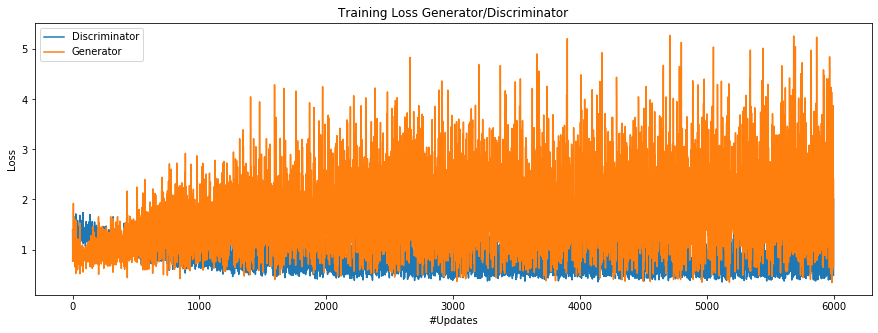

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(loss_list_dis)
plt.plot(loss_list_gen)
plt.xlabel('#Updates')
plt.ylabel('Loss')
plt.title('Training Loss Generator/Discriminator')
plt.legend(['Discriminator', 'Generator'])
plt.show()

## Generating new Data

Generate noise vector and use this as an input for the generator network.  

Some of them seem pretty real (and there is no mode collapse). However, there is still room for improvement (e.g. bottom right). 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


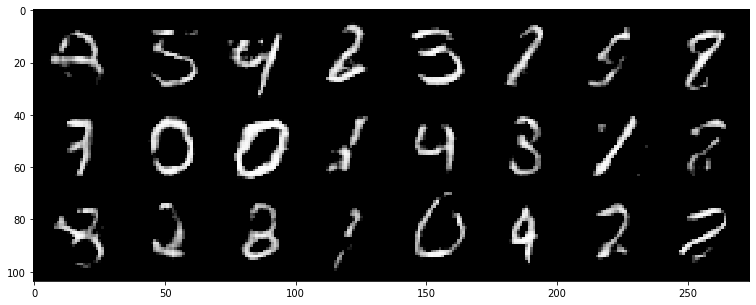

In [13]:
samples = 24
test_noise = torch.randn(samples, noise_size).to(device)
fake_data = generator(test_noise)
fake_data = fake_data.view(samples, 1, 32, 32)

grid = torchvision.utils.make_grid(fake_data, nrow=8)
plt.figure(figsize=(15, 5))
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.show()